In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, classification_report, ConfusionMatrixDisplay
from sklearn.utils import resample


In [2]:
def remove_iqr_outliers(df, column):
    Q1 = df[column].quantile(0.20)
    Q3 = df[column].quantile(0.80)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(lower_bound, upper_bound)
    
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    # return df[(df[column] < upper_bound)]

In [59]:
def data_loader(image_num, distance, features):
    """_summary_

    Args:
        image_num (int): image number to load the corresponding csv file
        distance (float): filter out distance
        features (list): list of features 
    """
    data = pd.read_csv(f'../data/processed/TopDown/max/STD/Image_{image_num}_max_STD.csv')
    entropy = pd.read_csv(f'../data/processed/TopDown/max/Entropy/Image_{image_num}_max_Entropy.csv')
    depth = pd.read_csv(f'../data/processed/TopDown/max/STD/Image_{image_num}_max_STD.csv')
    
    new_df = pd.DataFrame()

    new_df['max_STD'] = data['max_STD']
    new_df['max_Entropy'] = entropy['max_Entropy']
    new_df['depth_value'] = depth['depth_value'] 
    new_df['x'] = depth['x'] 
    new_df['y'] = depth['y'] 
    
    new_df["label"] = np.where(new_df['depth_value'] <= distance, 1, 0)

    max_labels = new_df[new_df.label == 0]
    min_labels = new_df[new_df.label == 1]

    max_down = resample(max_labels,
                        replace=False,
                        n_samples=len(min_labels),     # match minority
                        random_state=42)

    df_balanced = pd.concat([max_down, min_labels])
    
    print(df_balanced['label'].value_counts())
    
    X = df_balanced[features]
    y = df_balanced['label']
    
    return X, y

In [ ]:
# new_df = new_df[(new_df['depth_value'] >= 0.0)&(new_df['depth_value'] <= 0.009)]
# new_df = remove_iqr_outliers(new_df, 'max_STD')
# new_df = new_df[(new_df['max_STD'] >= 0.0)&(new_df['max_STD'] <= 0.07)]
#new_df.head()

,max_STD,max_Entropy,depth_value,x,y,label
0,0.19,2.78,1.64,0,0,0
1,0.18,2.78,1.63,0,1,0
2,0.17,2.69,1.63,0,2,0
3,0.17,2.69,1.63,0,3,0
4,0.17,2.69,1.63,0,4,0


In [ ]:
#sns.scatterplot(x=df_balanced['max_STD'], y=df_balanced['label'])
# sns.boxplot(new_df['max_STD'])
#plt.show()

label
0    3508
1    3508
Name: count, dtype: int64

MLP Classification Evaluation:
accuracy_score: 0.8811
classification_report:               precision    recall  f1-score   support

           0       0.90      0.86      0.88       705
           1       0.87      0.90      0.88       699

    accuracy                           0.88      1404
   macro avg       0.88      0.88      0.88      1404
weighted avg       0.88      0.88      0.88      1404

Confusion matrix (rows = actual, cols = predicted):
[[609  96]
 [ 71 628]]


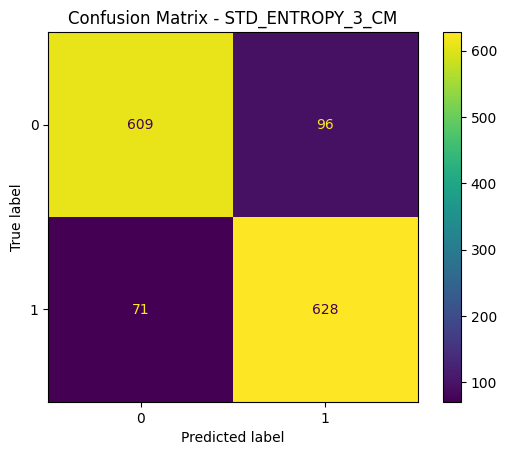

In [61]:
DIR = "logs"
SAMPLING = "TopDown"
# EXP_NAME = "STD_3_CM"
EXP_NAME = "STD_ENTROPY_3_CM"

X, y = data_loader(15, 0.009, ['max_STD', 'max_Entropy'])

try:
    if not os.path.isdir(os.path.join("../", DIR, SAMPLING, EXP_NAME)):
        os.mkdir(os.path.join("../",DIR, SAMPLING, EXP_NAME))
except:
     print("Folder Exist")
        

X= X.to_numpy()
y= y.to_numpy()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # # Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# # Train MLP Regressor Model
model = MLPClassifier(hidden_layer_sizes=(8,16), activation='relu', solver='adam', max_iter=2000, random_state=42)

# model = SVC(kernel="linear", C=0.025, random_state=42)

# model = SVC(gamma=2, C=1, random_state=42)
# model = GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42)

model.fit(X_train_scaled, y_train)

# clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
# models,predictions = clf.fit(X_train, X_test, y_train, y_test)
# models

# Evaluate model
predictions = model.predict(X_test_scaled)
print("\nMLP Classification Evaluation:")
print(f'accuracy_score: {accuracy_score(y_test, predictions):.4f}')
print(f'classification_report: {classification_report(y_test, predictions)}')
# print(f'R^2 Score: {r2_score(y_test, predictions):.4f}')

with open(os.path.join("../", DIR, SAMPLING, EXP_NAME, "classification_report.txt"), "a") as f:
    f.write(classification_report(y_test, predictions))
    
cm = confusion_matrix(y_test, predictions, labels=None)  # labels=None ⇒ inferred
print("Confusion matrix (rows = actual, cols = predicted):")
print(cm)

 # Optional: pretty plotted version
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format='d')          # integer formatting
plt.title(f"Confusion Matrix - {EXP_NAME}")
plt.savefig(os.path.join("../", DIR, SAMPLING, EXP_NAME, "confussion_matrix.png"))
plt.show()